# First attempt to pythonise Mike's code and apply it to MERRA2

In [15]:
import sys
import os
import glob
import xarray as xr
import numpy as np
import gc
import logging
import pandas as pd

In [2]:
#relevant directories (move to utils.py eventually)
MERRA2_T2M_U2M_QV2M_dir = '/g/data/rr7/MERRA2/raw/M2T1NXSLV.5.12.4'
MERRA2_SWNETSRF_dir = '/g/data/rr7/MERRA2/raw/M2T1NXINT.5.12.4'
MERRA2_SWGDN_dir = '/g/data/rr7/MERRA2/raw/M2T1NXRAD.5.12.4/'

#### Dask + warning setup

In [3]:
import warnings
import logging
warnings.filterwarnings('ignore') 
logging.getLogger("distributed.worker.memory").setLevel(logging.ERROR)
logging.getLogger('flox').setLevel(logging.WARNING)

In [4]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45707/status,
Dashboard: /proxy/45707/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37437,Workers: 10
Dashboard: /proxy/45707/status,Total threads: 10
Started: Just now,Total memory: 586.73 GiB
Comm: tcp://127.0.0.1:46103,Total threads: 1
Dashboard: /proxy/45755/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:43217,


### Step 1 -> Extract daily T, q, Rd, U10 and convert to 7-day running means 

Hourly MERRA2 files are very large - extract only relevant variables for domain of interest with dask and write locally (only need to do this step once)<br>
<sub>Need to write locally as working with dask arrays using .compute crashes the session and takes a long time</sub>

In [5]:
%%time
#load in 2m air temperature (K), 2m eastward wind speed (m/s), 2m specific humidity (kg/kg) and aggregate to daily timescale
T2M_U2M_QV2M_files = []
for year in range(1980,2023):
    for month in range(1,13):
        T2M_U2M_QV2M_files.extend(sorted(glob.glob(f"{MERRA2_T2M_U2M_QV2M_dir}/{year}/{str(month).zfill(2)}/*.nc4")))

def preprocess_T2M_U2M_QV2M(ds): #preprocess function to save memory and time
    logging.getLogger('flox').setLevel(logging.WARNING)
    return ds[['T2M', 'U2M', 'QV2M']].resample(time='1D').mean().sel(lat=slice(-45,-1), lon=slice(100,180))

T2M_U2M_QV2M_cube = xr.open_mfdataset(T2M_U2M_QV2M_files,combine='nested', concat_dim='time',parallel=True, preprocess=preprocess_T2M_U2M_QV2M, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'})

#write to netcdf and clear up local memory, ok to store locally only takes ~1.5gb
T2M_U2M_QV2M_cube.to_netcdf('/g/data/mn51/users/jb6465/MERRA2_daily_T2M_U2M_QV2M.nc', encoding={'T2M': {'zlib': True, 'complevel': 5, 'dtype':'float32'}, 'U2M': {'zlib': True, 'complevel': 5, 'dtype':'float32'}, 'QV2M': {'zlib': True, 'complevel': 5, 'dtype':'float32'}})
del T2M_U2M_QV2M_cube
gc.collect()

CPU times: user 1h 33min 55s, sys: 6min 2s, total: 1h 39min 58s
Wall time: 2h 15min 1s


15373

In [6]:
%%time
#load in incoming surface solar radiation (W/m2) and aggregate to daily timescale
SWGDN_files = []
for year in range(1980,2023):
    for month in range(1,13):
        SWGDN_files.extend(sorted(glob.glob(f"{MERRA2_SWGDN_dir}/{year}/{str(month).zfill(2)}/*.nc4")))

def preprocess_SWdn(ds): #preprocess function to save memory and time
    logging.getLogger('flox').setLevel(logging.WARNING)
    return ds['SWGDN'].resample(time='1D').mean().sel(lat=slice(-45,-1), lon=slice(100,180))

SWGDN_cube = xr.open_mfdataset(SWGDN_files,combine='nested', concat_dim='time',parallel=True, preprocess=preprocess_SWdn, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'})

#write to netcdf and clear up local memory, ok to store locally only takes ~500mb
SWGDN_cube.to_netcdf('/g/data/mn51/users/jb6465/MERRA2_daily_SWGDN.nc', encoding={'SWGDN': {'zlib': True, 'complevel': 5, 'dtype':'float32'}})
del SWGDN_cube
gc.collect()

CPU times: user 34min 1s, sys: 1min 54s, total: 35min 56s
Wall time: 46min 33s


13735

<b> Convert daily to 7-day running means </b>

In [41]:
%%time
T2M_U2M_QV2M_cube = xr.open_dataset('/g/data/mn51/users/jb6465/MERRA2_daily_T2M_U2M_QV2M.nc')
SWGDN_cube = xr.open_dataset('/g/data/mn51/users/jb6465/MERRA2_daily_SWGDN.nc')

T2M_7d_mean = T2M_U2M_QV2M_cube['T2M'].rolling(time=7).mean()
U2M_7d_mean = T2M_U2M_QV2M_cube['U2M'].rolling(time=7).mean()
QV2M_7d_mean = T2M_U2M_QV2M_cube['QV2M'].rolling(time=7).mean()
SWGDN_7d_mean = SWGDN_cube['SWGDN'].rolling(time=7).mean()

CPU times: user 15.9 s, sys: 1.72 s, total: 17.6 s
Wall time: 17.6 s


<br> 

### Step 2 -> Calculate daily reference ET and convert to 7-day running means

<b>MERRA2 elev</b><br>
Following approach from Mike's [MERRA2 paper code](https://www.sciencebase.gov/catalog/item/6515cb7ad34e469cabfcdccd), elev file not stored on gadi so downloaded locally from NASA earthdata

In [63]:
elevfile = xr.open_dataset('/g/data/mn51/users/jb6465/MERRA2_101.const_2d_asm_Nx.nc4')

#MERRA2 elevation derived from PHIS (surface geopotenial height in m2/m2)
geopot = elevfile['PHIS'].sel(lat=slice(-45,-1), lon=slice(100,180)).values
elev = geopot/9.81 #divide by 9.81m2/s to get elevation in m

Calculate Ref ET using approximations<br>
[FAO56 ASCE05 constants and equations](http://www.climasouth.eu/sites/default/files/FAO%2056.pdf)<br>
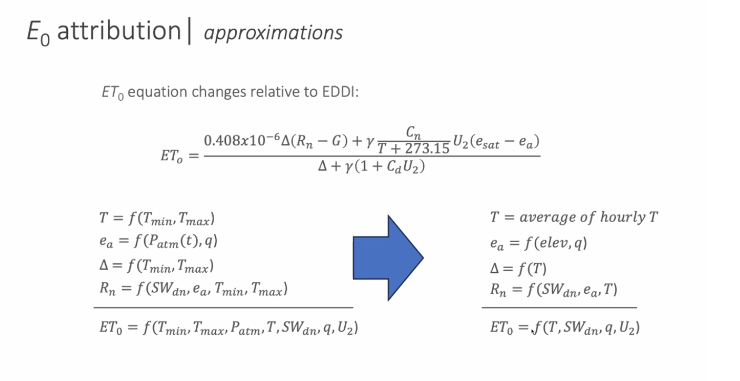

<b>Switch for short/tall crop<b>

In [50]:
short_tall_crop_switch = 'short' #short (0.12m grass) or tall (0.50m alfafa)

<b>Input variables</b>

In [173]:
%%time
from math import pi

T2M = T2M_7d_mean.values
U2M = U2M_7d_mean.values
QV2M = QV2M_7d_mean.values
SWGDN = SWGDN_7d_mean.values 

# delta: slope of saturation vapor pressure curve (Pa/K) 
delta = 4098 * 610.8 * np.exp((17.27*(T2M-273.15))/(T2M-35.85)) / (T2M-35.85)**2 

# psyc: psychrometric constant (Pa/K)
patm = 101300 * ((293. - 0.0065 * elev) / 293.)**5.26
psyc = 0.000665 * patm

# Cn: numerator crop constant (K.mm.sec3/kg/day)
Cn = 1600 if short_tall_crop_switch == 'tall' else 900 

# Cd: denominator crop constant (sec/m)
Cd = 0.38 if short_tall_crop_switch == 'tall' else 0.34

# esat: saturation vapor pressure (Pa)
esat = 610.8 * np.exp((17.27*(T2M-273.15)) / (T2M - 35.85))

# eact: vapor pressure (Pa) 
eact = patm * (QV2M/(1-QV2M)) / (0.622+(QV2M/(1-QV2M)))

# albedo (unitless)
albedo = 0.23

# sigma: Stefan-Boltzmann constant (MJ/K4/m2/day)
sigma = 4.901e-9

# Rn: downward net radiation (W/m^2)
Rn = np.ma.empty_like(SWGDN)
for day_idx, day in enumerate(np.array(SWGDN_7d_mean.time.values)):
    doy = pd.Timestamp(day).dayofyear
    decl = 0.409 * np. sin((2. * pi * doy / 365) - 1.39) #declination (rad)
    
    lonrad, latrad = np.meshgrid(np.radians(SWGDN_7d_mean.lon.values),np.radians(SWGDN_7d_mean.lat.values)) #convert latitude array to radians (rad)
    ws = -1. * np.tan(latrad) * np.tan(decl) #sunset hour angle (rad)
    dr = 1. + 0.033 * np.cos(2. * pi * doy / 365) #inverse relative distance of earth from sun (unitless)
    Gsc = 4.92 #solar constant (MJ/m2/hour)

    Ra = (24. / pi) * Gsc * dr * (ws * np.sin(latrad) * np.sin(decl) + np.cos(latrad) * np.cos(decl) * np.sin(ws)) #extra-terrestrial (TOA) SW radiation (MJ/m2/day)
    Rs = SWGDN[day_idx] #MERRA2 incoming surface solar radiation (W/m2)
    Rso = Ra * (0.75 + 2.e-5 * elev[0]) #clear-sky SW radiation at surface (MJ/m2/day)
    RsRso = (Rs * 86400. / 1.e6) / Rso #relative shortwave radiation (unitless)
    fcd = 1.35 * RsRso - 0.35 #cloudiness function (unitless)
    Rnsw = Rs * (1 - albedo) #downward net shortwave radiation (W/m^2)
    Rnl = sigma * fcd * (0.34 - 0.14 * (0.001 * eact[day_idx])**0.5) * (T2M[day_idx] - 35.85)**4. #upward net longwave radiation (W/m^2)
    Rn[day_idx,:,:] = Rnsw - (Rnl * 1000000 / 86400) #downward net radiation (W/m^2)

#ground heat flux (J/m2/day)
G = 0 #on daily time scales, G is too small relative to Rn and is considered null


CPU times: user 22.9 s, sys: 2.74 s, total: 25.6 s
Wall time: 25.6 s


<b>Split ETr into 3 components: A, B, C,<b>

In [174]:
%%time
# A left numerator
A = 0.408e-6 * delta * Rn - G

# B right numerator
B = psyc * (Cn/T2M) * U2M * (esat-eact)

# C denominator
C = delta + psyc * (1+Cd*U2M)

ETr = (A+B)/C

CPU times: user 4.91 s, sys: 3.98 s, total: 8.89 s
Wall time: 8.88 s


In [175]:
ETr_xr = xr.DataArray(ETr, dims=['time', 'lat', 'lon'], coords={'time':T2M_7d_mean.time.values, 'lat': T2M_7d_mean.lat.values, 'lon': T2M_7d_mean.lon.values}).rename(f"ETr_{short_tall_crop_switch}_crop")

Convert daily to 7-day running means

In [176]:
ETr_7d_mean = ETr_xr.rolling(time=7).mean()

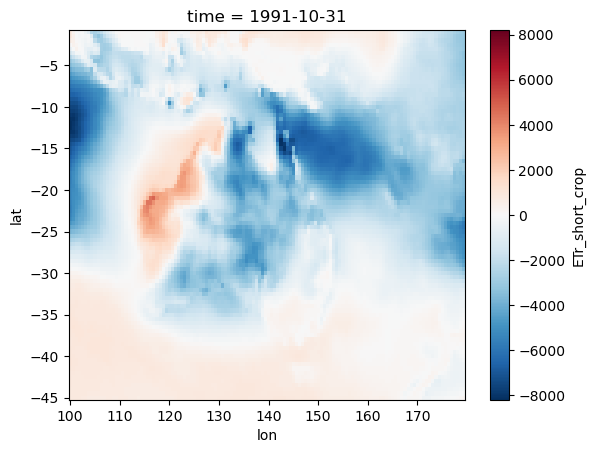

In [177]:
ETr_7d_mean[4321].plot()

<br>

### Step 3 -> Calculate daily sensitivity expressions

Relevant Equations

<br>

### Step 4 -> Calculate relative contribution from each driver

<br>

### Step 5 -> Plot and visualise 